In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import munkres
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import math

In [56]:
def is_dense(x):
    return True if str(x)[37:].split(' ')[0]=='Dense' else False
def is_conv2d(x):
    return True if str(x)[46:].split(' ')[0]=='Conv2D' else False

#Hard Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
                        
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
            worse_part+=tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by))
            worse_numerator+=worse_part
            
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)

            for i in range(ln):
                group_dead.append(tf.concat([x[:,i], [by[i]]], axis=0))
                group_undead.append(tf.concat([y[:,i], [by[i]]], axis=0))

            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())

            m = munkres.Munkres()
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1

            eld=y@transformator_lefty
            post_eld=tf.einsum('j,jj->j', by, transformator_lefty)
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    point=ij+1
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    point=ij+2
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    point=ij+3
                else:
                    point=None
                if point is not None:
                    neue=transformator_righty@undead_model.layers[point].weights[0]
                    
            better_part=tf.reduce_sum((x-eld)*(x-eld))+tf.reduce_sum((bx-post_eld)*(bx-post_eld))
            better_numerator+=better_part
            
            denominator_part=(x.shape[0]*x.shape[1])+bx.shape[0]
            denominator+=denominator_part
            print (f'LOG normal:    {worse_part/denominator_part}')
            print (f'LOG hungarian: {better_part/denominator_part}')
    return worse_numerator/denominator, worse_numerator/denominator

#Eazy Cost
def slaby_kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x) or is_conv2d(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
                
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by))
            denominator+=(x.shape[0]*x.shape[1])+bx.shape[0]
            print (f'LOG normal:    {(tf.reduce_sum((x-y)*(x-y))+tf.reduce_sum((bx-by)*(bx-by)))/(x.shape[0]*x.shape[1]+bx.shape[0])}')
            #print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator

In [76]:
def model_generator1(weights=None, dropout_rate=0.0, bnorm=False, momentum=0.99, conv=False, conv_weights=None):
    activations=["sigmoid", "sigmoid", "relu", "tanh", "sigmoid"]
    units=[50, 100, 100, 100, 5]
    
    if weights!=None:
        init, init2, init3=[], [], [] #Kolejno: W, bias, Conv
        for i in range(len(weights)):
            init.append(tf.constant_initializer(weights[i][0].numpy()))
            init2.append(tf.constant_initializer(weights[i][1].numpy()))
        if conv==True:
            for i in range(len(conv_weights)):
                init3.append(tf.constant_initializer(conv_weights[i][0].numpy()))
    # Tworzenie densów poprzecinanych dropoutami (domyślnie z rate=0 - tak, żeby nie miały wpływu na kalkulacje)
    lst=[]
    
    if conv==True:
        for i in range(2):
            if weights!=None:
                lst.append(tf.keras.layers.Conv2D(filters=10, kernel_size=(2,2), padding='same', kernel_initializer=init3[i]))
            else:
                lst.append(tf.keras.layers.Conv2D(filters=10, kernel_size=(2,2), padding='same'))
            lst.append(tf.keras.layers.Dropout(dropout_rate))
            lst.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
            if bnorm==True:
                lst.append(tf.keras.layers.BatchNormalization(momentum=momentum))        
        lst.append(tf.keras.layers.Flatten())
        activations=["sigmoid", "sigmoid", "sigmoid"]
        units=[70, 50, 5]
    
    v=0
    for u, act in zip(units, activations):
        if v>0 and bnorm==True:
            lst.append(tf.keras.layers.BatchNormalization(momentum=momentum)) #Bnorm
        if v>0:
            lst.append(tf.keras.layers.Dropout(dropout_rate)) #Dropout
        if weights!=None:
            lst.append(tf.keras.layers.Dense(units=u, activation=act, kernel_initializer=init[v], bias_initializer=init2[v])) #Przygotowana waga
        else:
            lst.append(tf.keras.layers.Dense(units=u, activation=act, bias_initializer=tf.random.normal)) # Nieprzygotowana waga
        v+=1
    
    return tf.keras.Sequential(lst)

In [77]:
def generate_system(inputs, instances):
    return tf.random.normal((instances, *inputs))

def testo(eval_set, ideal_y, neural):
    predicted_y=neural(eval_set)
    optim=tf.keras.losses.MeanSquaredError()
    return optim(predicted_y, ideal_y)

def generate_all_models(sol_type, weights, training_x, test_x, weight_decay=None, batch_size=32, **kwargs):
    ideal = model_generator1(weights, **kwargs)
    training_y, test_y=ideal(training_x), ideal(test_x)
    epochs=3
    results={}
    
    if weight_decay is not None:
        optimizers=[['sgdw', tf.keras.optimizers.SGD(weight_decay)], ['adamw', tfa.optimizers.AdamW(weight_decay)]]
    else:
        optimizers=[['sgd', tf.keras.optimizers.SGD()], ['adam', tf.keras.optimizers.Adam()], ['adamw', tfa.optimizers.AdamW(0.0001)]]
    
    for opt in optimizers:
        imperfect = model_generator1(**kwargs)
        imperfect.compile(optimizer=opt[1], loss='mse')
        imperfect.fit(training_x.numpy(), training_y.numpy(), epochs=epochs, batch_size=batch_size)
        results_train = testo(training_x, training_y, imperfect)
        results_test = testo(test_x, test_y, imperfect)
        print(f"TRAINO {opt[0]}: {results_train}")
        print(f"TESTO {opt[0]}:  {results_test}")
        
        post_fact=[kwargs[v] for v in kwargs if v!='conv_weights']
        #print(post_fact, [opt[0], weight_decay, batch_size])
        real_fact=[sol_type, opt[0], weight_decay, batch_size]
        real_fact.extend((post_fact))
        if 'conv' in kwargs and kwargs['conv']==True:
            results[tuple(real_fact)]=(results_train, results_test, slaby_kost(ideal, imperfect))
        else:
            results[tuple(real_fact)]=(results_train, results_test, kost(ideal, imperfect))
    return results
    
def test_hiperparams(number_of_weights=1, conv=False):
    significations=[]
    for ij in range(number_of_weights):
        train_instances_no, test_instances_no, inputs=50000, 10000, [10]
        if conv==True:
            train_instances_no, test_instances_no, inputs=20000, 5000, [10, 10, 3]
            
        ideal = model_generator1(conv=conv)
        training_x, test_x = generate_system(inputs, train_instances_no), generate_system(inputs, test_instances_no)
        training_y, test_y = ideal(training_x), ideal(test_x)

        weights=[]
        conv_weights=[]
        for x in ideal.layers:
            if is_conv2d(x):
                conv_weights.append(x.weights)
            if is_dense(x):
                weights.append(x.weights)
        signification={}
        for i in range(0, 6):
            print(f'Dropout eval, rate {i/10}')
            signification={**signification, **generate_all_models('dropout', weights, training_x, test_x, dropout_rate=i/10, conv=conv, conv_weights=conv_weights)}

        for i in range(2, 9, 2):
            for j in [0.1, 0.5, 0.9, 0.95, 0.99, 0.999]:
                print(f'Dropout eval, momentum {j}, batch_size {2**i}')
                signification={**signification, **generate_all_models('batch_norm', weights, training_x, test_x, batch_size=2**i, bnorm=True, momentum=j, conv=conv, conv_weights=conv_weights)}

        dissolution=[0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        for i in dissolution:
            signification={**signification, **generate_all_models('weight_decay', weights, training_x, test_x, weight_decay=i, conv=conv, conv_weights=conv_weights)}
        significations.append(signification)
    return significations
#res1=test_hiperparameters() # Uruchomienie testów - około 1.5h
res1=test_hiperparams(conv=False)
res2=test_hiperparams(conv=True)

Dropout eval, rate 0.0
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0686
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 9.2669e-04
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 7.2384e-05
TRAINO sgd: 3.711718454724178e-05
TESTO sgd:  3.710948658408597e-05
Processed layer: 0
LOG normal:    0.6754510998725891
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    1.4453767538070679
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
LOG normal:    0.07408252358436584
Processed layer: 8
Processed layer: 9
LOG normal:    0.05017542093992233
Processed layer: 10
Processed layer: 11
LOG normal:    0.11159981787204742
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0035
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 1.8106e-05
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 1.6092e-05
TRAINO ada

625/625 [==============================] - 1s 2ms/step - loss: 7.1385e-04
TRAINO adamw: 4.035747406305745e-05
TESTO adamw:  4.025081216241233e-05
Processed layer: 0
LOG normal:    0.5422722101211548
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    1.3585675954818726
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
LOG normal:    0.06507553905248642
Processed layer: 8
Processed layer: 9
LOG normal:    0.05002690851688385
Processed layer: 10
Processed layer: 11
LOG normal:    0.06321828812360764
Dropout eval, rate 0.4
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0536
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0202
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0176
TRAINO sgd: 0.0006378719699569046
TESTO sgd:  0.0006352965719997883
Processed layer: 0
LOG normal:    0.7822876572608948
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal

5000/5000 [==============================] - 5s 1ms/step - loss: 0.0028
Epoch 2/3
5000/5000 [==============================] - 5s 1ms/step - loss: 3.7142e-05
Epoch 3/3
5000/5000 [==============================] - 5s 1ms/step - loss: 2.1015e-05
TRAINO adam: 1.7886164641822688e-05
TESTO adam:  1.7998614566749893e-05
Processed layer: 0
LOG normal:    0.6261629462242126
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.4586457014083862
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.07849767804145813
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.054714277386665344
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.038358621299266815
Epoch 1/3
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0035
Epoch 2/3
5000/5000 [==============================] - 5s 1ms/step - loss: 2.0891e-05
Epoch 3/3
5000/5000 [==========

5000/5000 [==============================] - 5s 1ms/step - loss: 0.0036
Epoch 2/3
5000/5000 [==============================] - 5s 1ms/step - loss: 1.9787e-05
Epoch 3/3
5000/5000 [==============================] - 5s 1ms/step - loss: 1.5509e-05
TRAINO adamw: 1.0918931366177276e-05
TESTO adamw:  1.0976882549584843e-05
Processed layer: 0
LOG normal:    0.3064862787723541
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    0.7726521492004395
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.03992564231157303
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.028663184493780136
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.040761951357126236
Dropout eval, momentum 0.999, batch_size 4
Epoch 1/3
5000/5000 [==============================] - 5s 1ms/step - loss: 0.0338
Epoch 2/3
5000/5000 [==============================] - 5s 977us/step - l

Epoch 1/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0467
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0176
Epoch 3/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0104
TRAINO sgd: 0.0070208352990448475
TESTO sgd:  0.007066717371344566
Processed layer: 0
LOG normal:    0.7016013860702515
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.6184407472610474
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.06754948198795319
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.061519917100667953
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.07221299409866333
Epoch 1/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0165
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 3.8035e-04
Epoch 3/3
1250/1250 [==============

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0058
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 2.9661e-04
Epoch 3/3
1250/1250 [==============================] - 2s 2ms/step - loss: 8.1333e-05
TRAINO adam: 9.557794692227617e-05
TESTO adam:  9.483804751653224e-05
Processed layer: 0
LOG normal:    0.7295271754264832
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.4414705038070679
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.06552840769290924
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.05610036104917526
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.05600624904036522
Epoch 1/3
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0056
Epoch 2/3
1250/1250 [==============================] - 2s 2ms/step - loss: 8.6856e-05
Epoch 3/3
1250/1250 [==============

313/313 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 5.4692e-04
TRAINO adamw: 0.0002321318897884339
TESTO adamw:  0.0002505153534002602
Processed layer: 0
LOG normal:    0.47373679280281067
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.3652375936508179
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.06154686212539673
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.0416790246963501
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.09221711754798889
Dropout eval, momentum 0.95, batch_size 64
Epoch 1/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1052
Epoch 2/3
313/313 [==============================] - 1s 4ms/step - loss: 0.0869
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0717
TRAINO s

Epoch 3/3
79/79 [==============================] - 0s 6ms/step - loss: 0.0819
TRAINO sgd: 0.0791342556476593
TESTO sgd:  0.07877663522958755
Processed layer: 0
LOG normal:    0.6136602163314819
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.3164472579956055
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.07883760333061218
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.05700555443763733
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.08034592866897583
Epoch 1/3
79/79 [==============================] - 0s 6ms/step - loss: 0.0755
Epoch 2/3
79/79 [==============================] - 1s 7ms/step - loss: 0.0251
Epoch 3/3
79/79 [==============================] - 0s 6ms/step - loss: 0.0046
TRAINO adam: 0.0028765248134732246
TESTO adam:  0.002811023034155369
Processed layer: 0
LOG normal:    0.6612548828125
Processed layer: 1
Proc

LOG normal:    0.06642652302980423
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.057222865521907806
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.09328699111938477
Epoch 1/3
79/79 [==============================] - 1s 6ms/step - loss: 0.0738
Epoch 2/3
79/79 [==============================] - 1s 6ms/step - loss: 0.0165
Epoch 3/3
79/79 [==============================] - 0s 6ms/step - loss: 0.0021
TRAINO adamw: 0.001253975904546678
TESTO adamw:  0.0013075490714982152
Processed layer: 0
LOG normal:    0.5740365982055664
Processed layer: 1
Processed layer: 2
Processed layer: 3
Processed layer: 4
LOG normal:    1.3691656589508057
Processed layer: 5
Processed layer: 6
Processed layer: 7
Processed layer: 8
Processed layer: 9
LOG normal:    0.07335980236530304
Processed layer: 10
Processed layer: 11
Processed layer: 12
LOG normal:    0.048771217465400696
Processed layer: 13
Processed layer: 14
Processed layer: 15
LOG normal:    0.100

625/625 [==============================] - 1s 2ms/step - loss: 0.0133
TRAINO adamw: 0.013279816135764122
TESTO adamw:  0.013286540284752846
Processed layer: 0
LOG normal:    0.3053279519081116
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    0.7303031086921692
Processed layer: 4
Processed layer: 5
Processed layer: 6
Processed layer: 7
LOG normal:    0.03755853325128555
Processed layer: 8
Processed layer: 9
LOG normal:    0.02647419646382332
Processed layer: 10
Processed layer: 11
LOG normal:    0.04238357022404671
Epoch 1/3
625/625 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 2/3
625/625 [==============================] - 1s 2ms/step - loss: 1.6434e-04
Epoch 3/3
625/625 [==============================] - 1s 2ms/step - loss: 4.9763e-05
TRAINO sgdw: 3.953647683374584e-05
TESTO sgdw:  3.9825550629757345e-05
Processed layer: 0
LOG normal:    0.5619720220565796
Processed layer: 1
Processed layer: 2
Processed layer: 3
LOG normal:    1.62758648395

In [78]:
def parser(significations):
    all_results=[]
    for single in significations:
        results={}
        for x in single:
            title=x[0] # Nazwa tuningu
            subtitle=x[1] # Nazwa grada
            if (title=='weight_decay'):
                value=x[2]
            if (title=='dropout'):
                value=x[4]
            if (title=='batch_norm'):
                value=x[3], x[5]

            if title not in results:
                results[title]={}

            if subtitle in results[title]:
                results[title][subtitle][title].append(value)
                results[title][subtitle]['train_y'].append(single[x][0].numpy())
                results[title][subtitle]['test_y'].append(single[x][1].numpy())
                results[title][subtitle]['w'].append(single[x][2][1].numpy())
            else:
                results[title][subtitle]={}
                results[title][subtitle][title]=[value]
                results[title][subtitle]['train_y']=[single[x][0].numpy()]
                results[title][subtitle]['test_y']=[single[x][1].numpy()]
                results[title][subtitle]['w']=[single[x][2][1].numpy()]
        all_results.append(results)
    return all_results

results1=parser(res1)[0]
results2=parser(res2)[0]

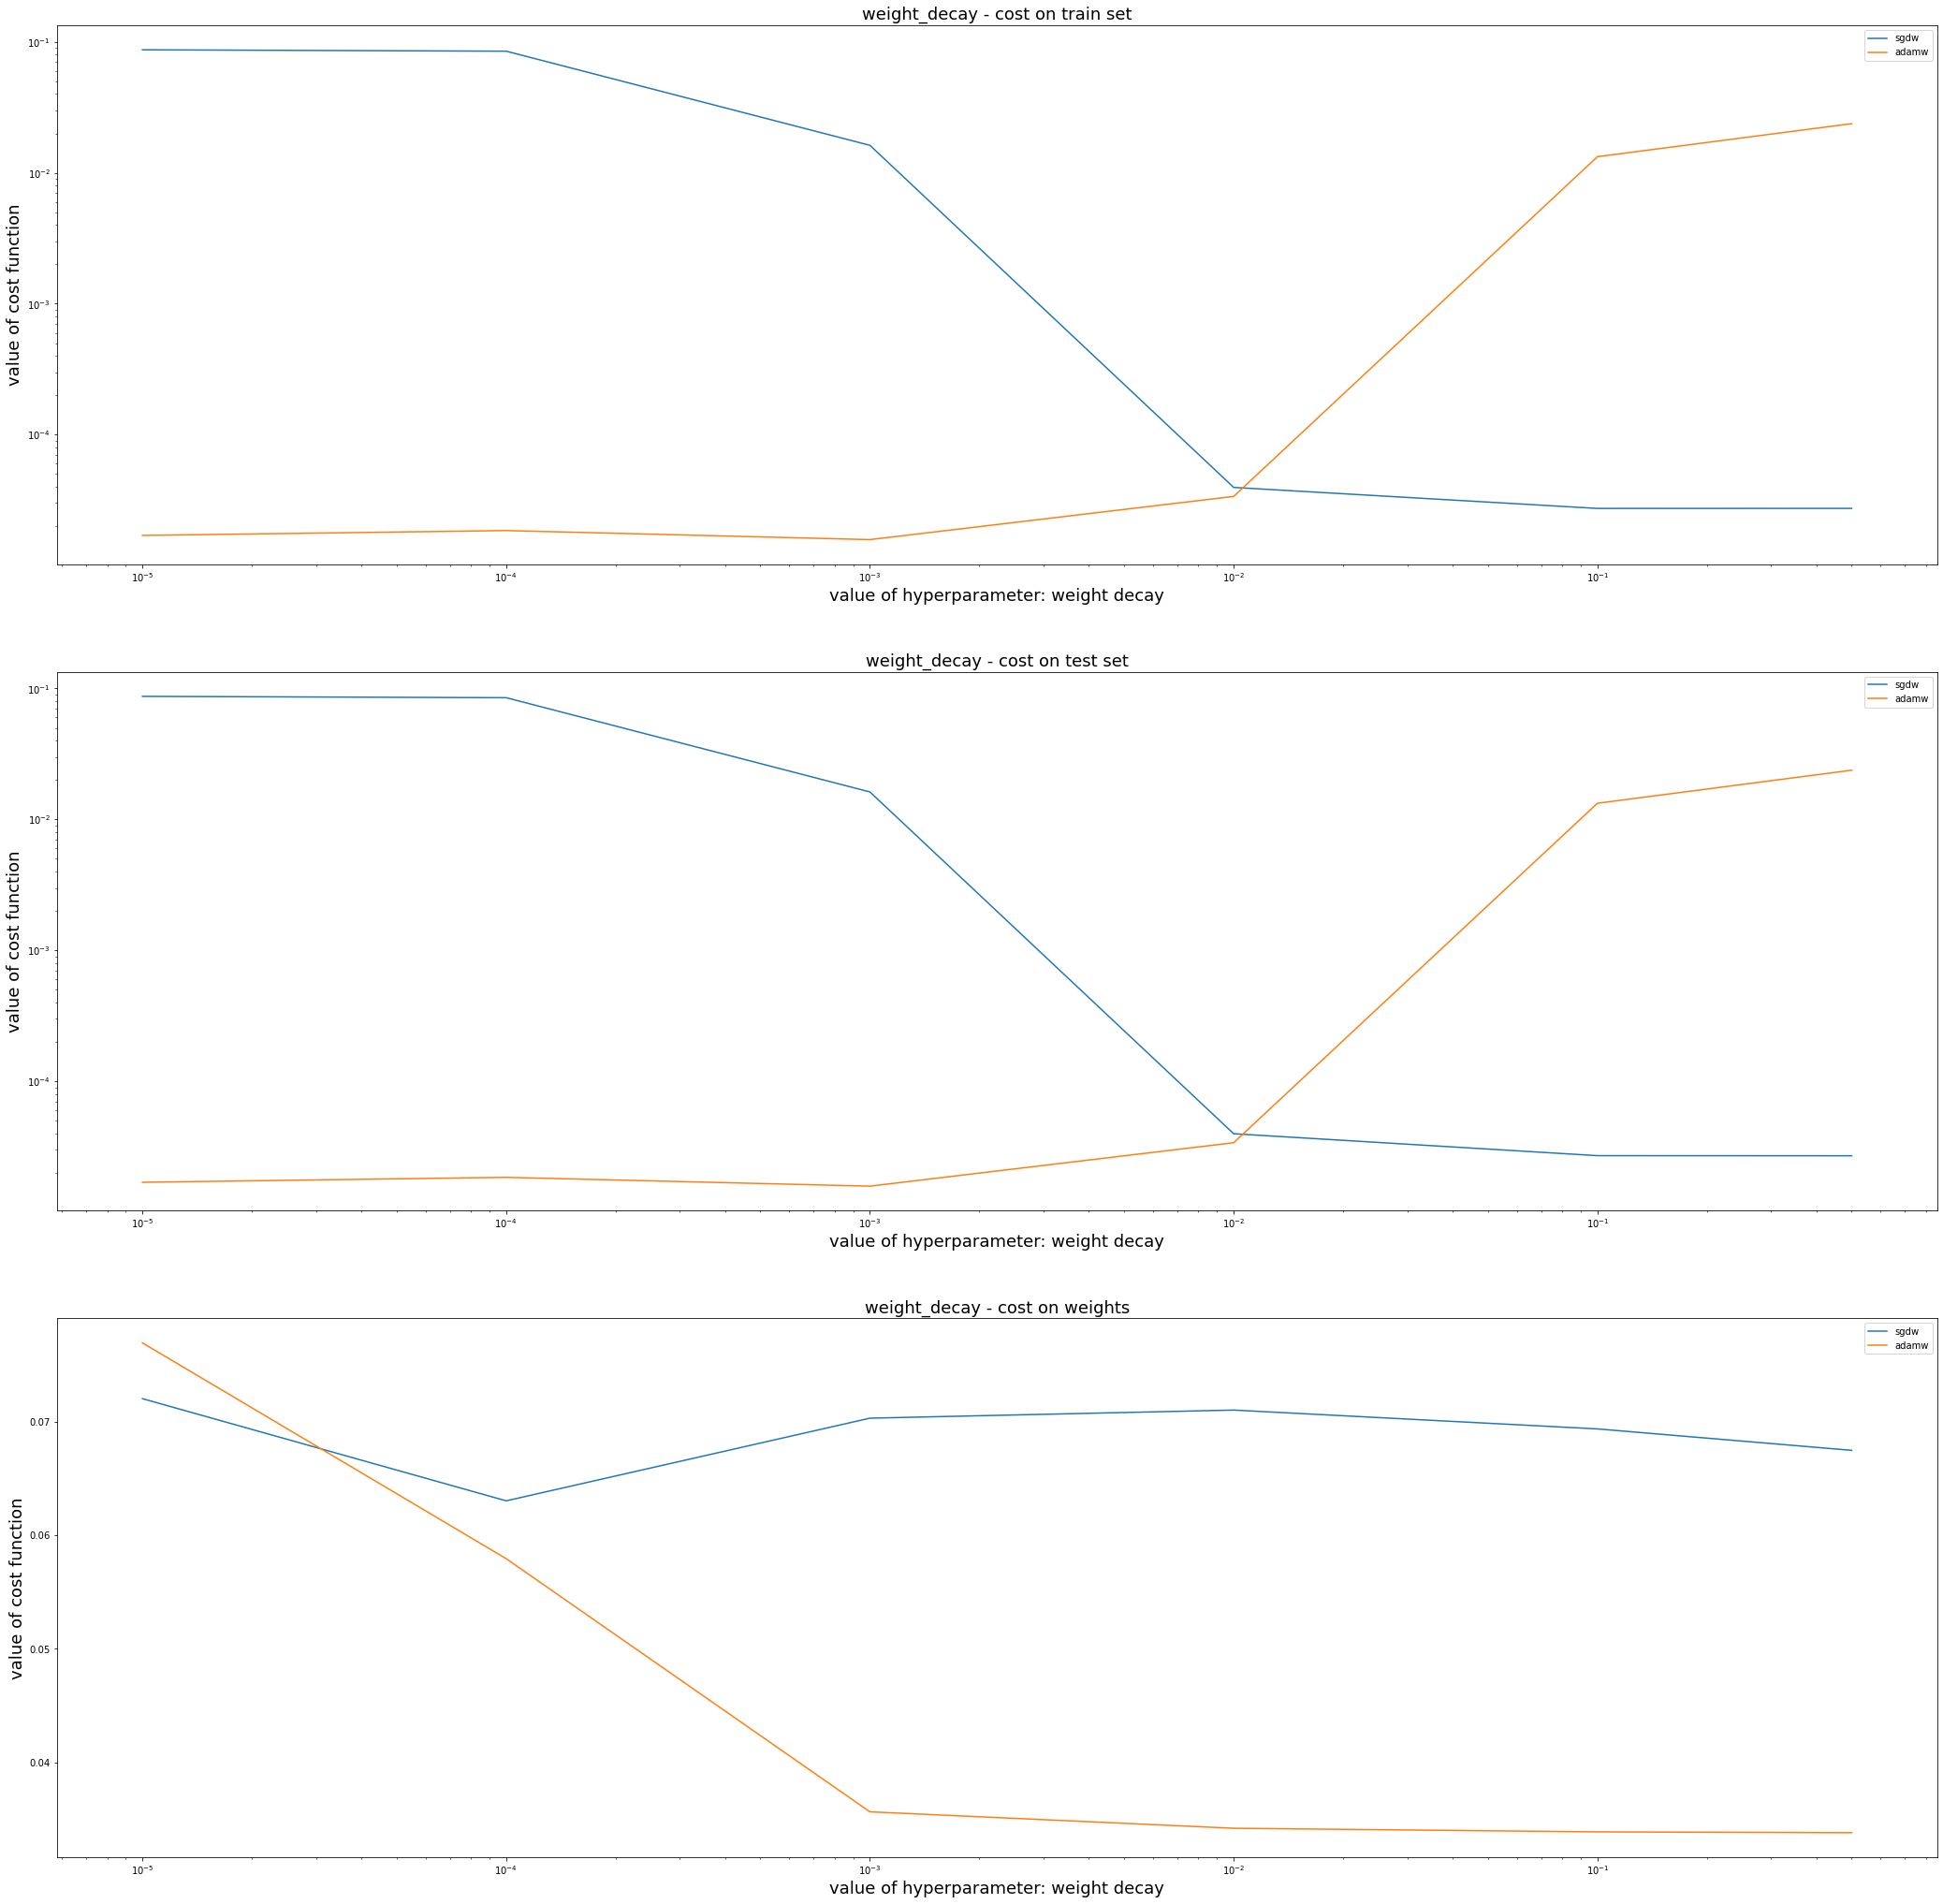

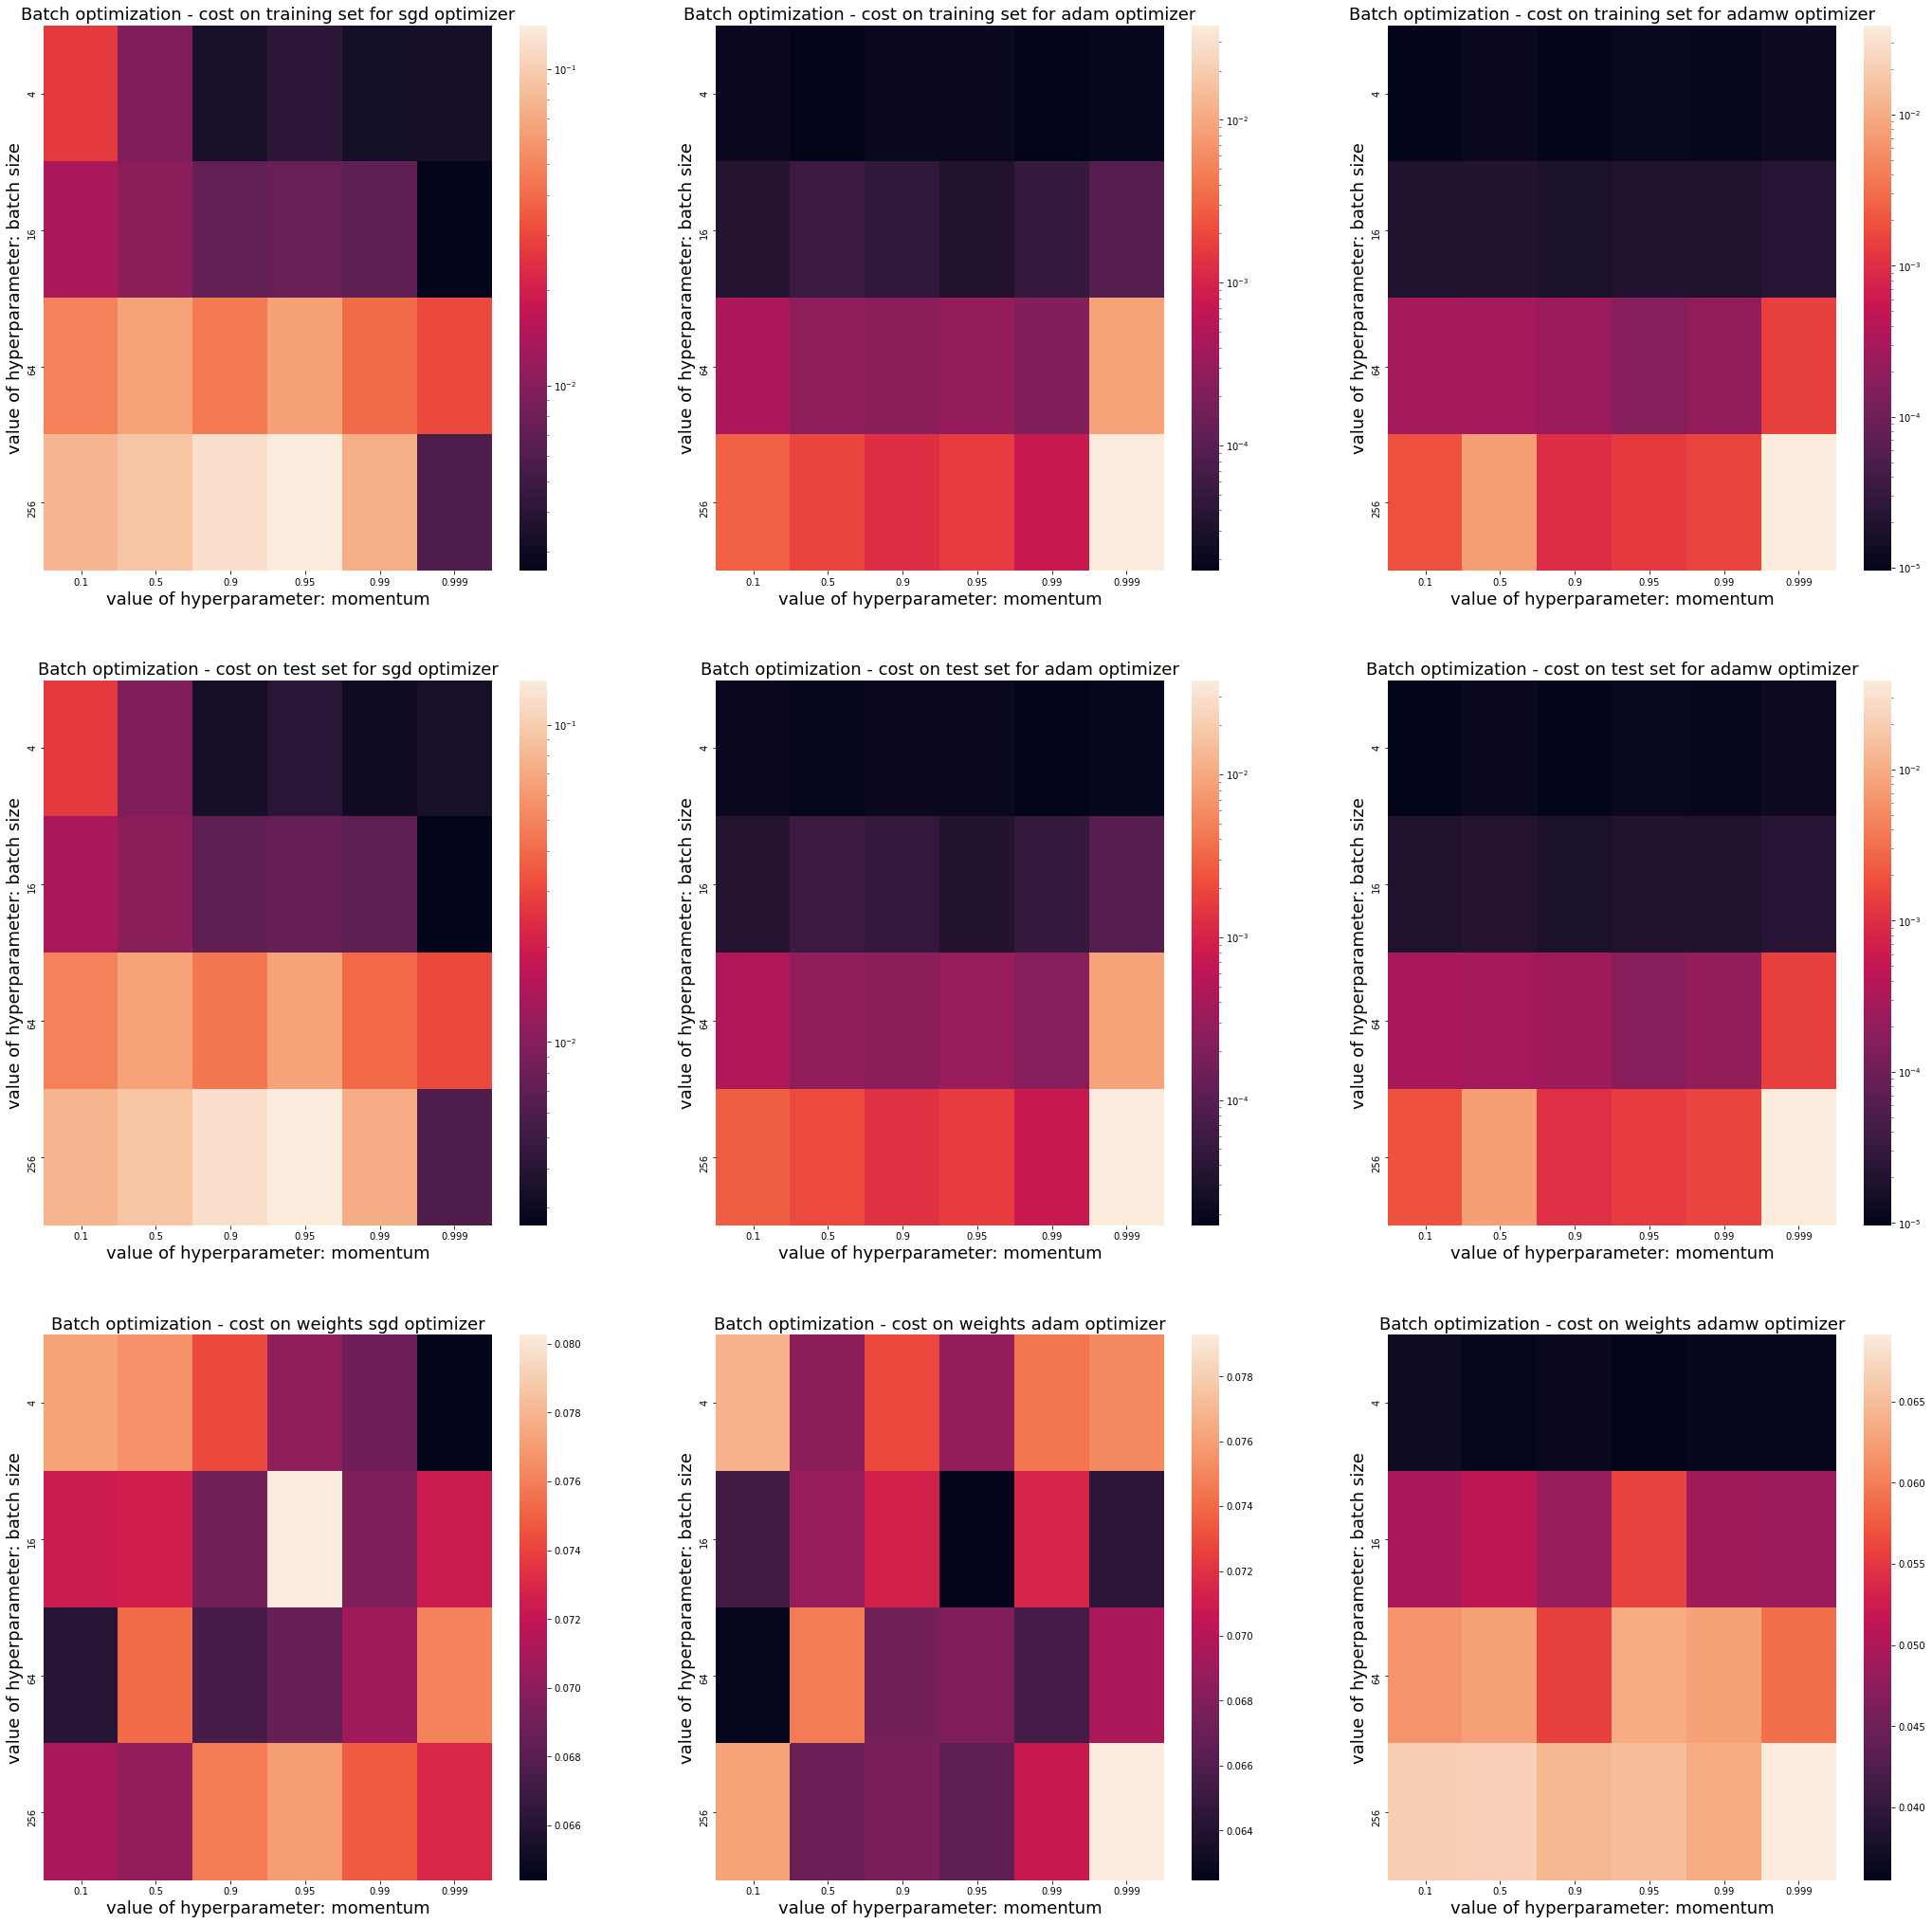

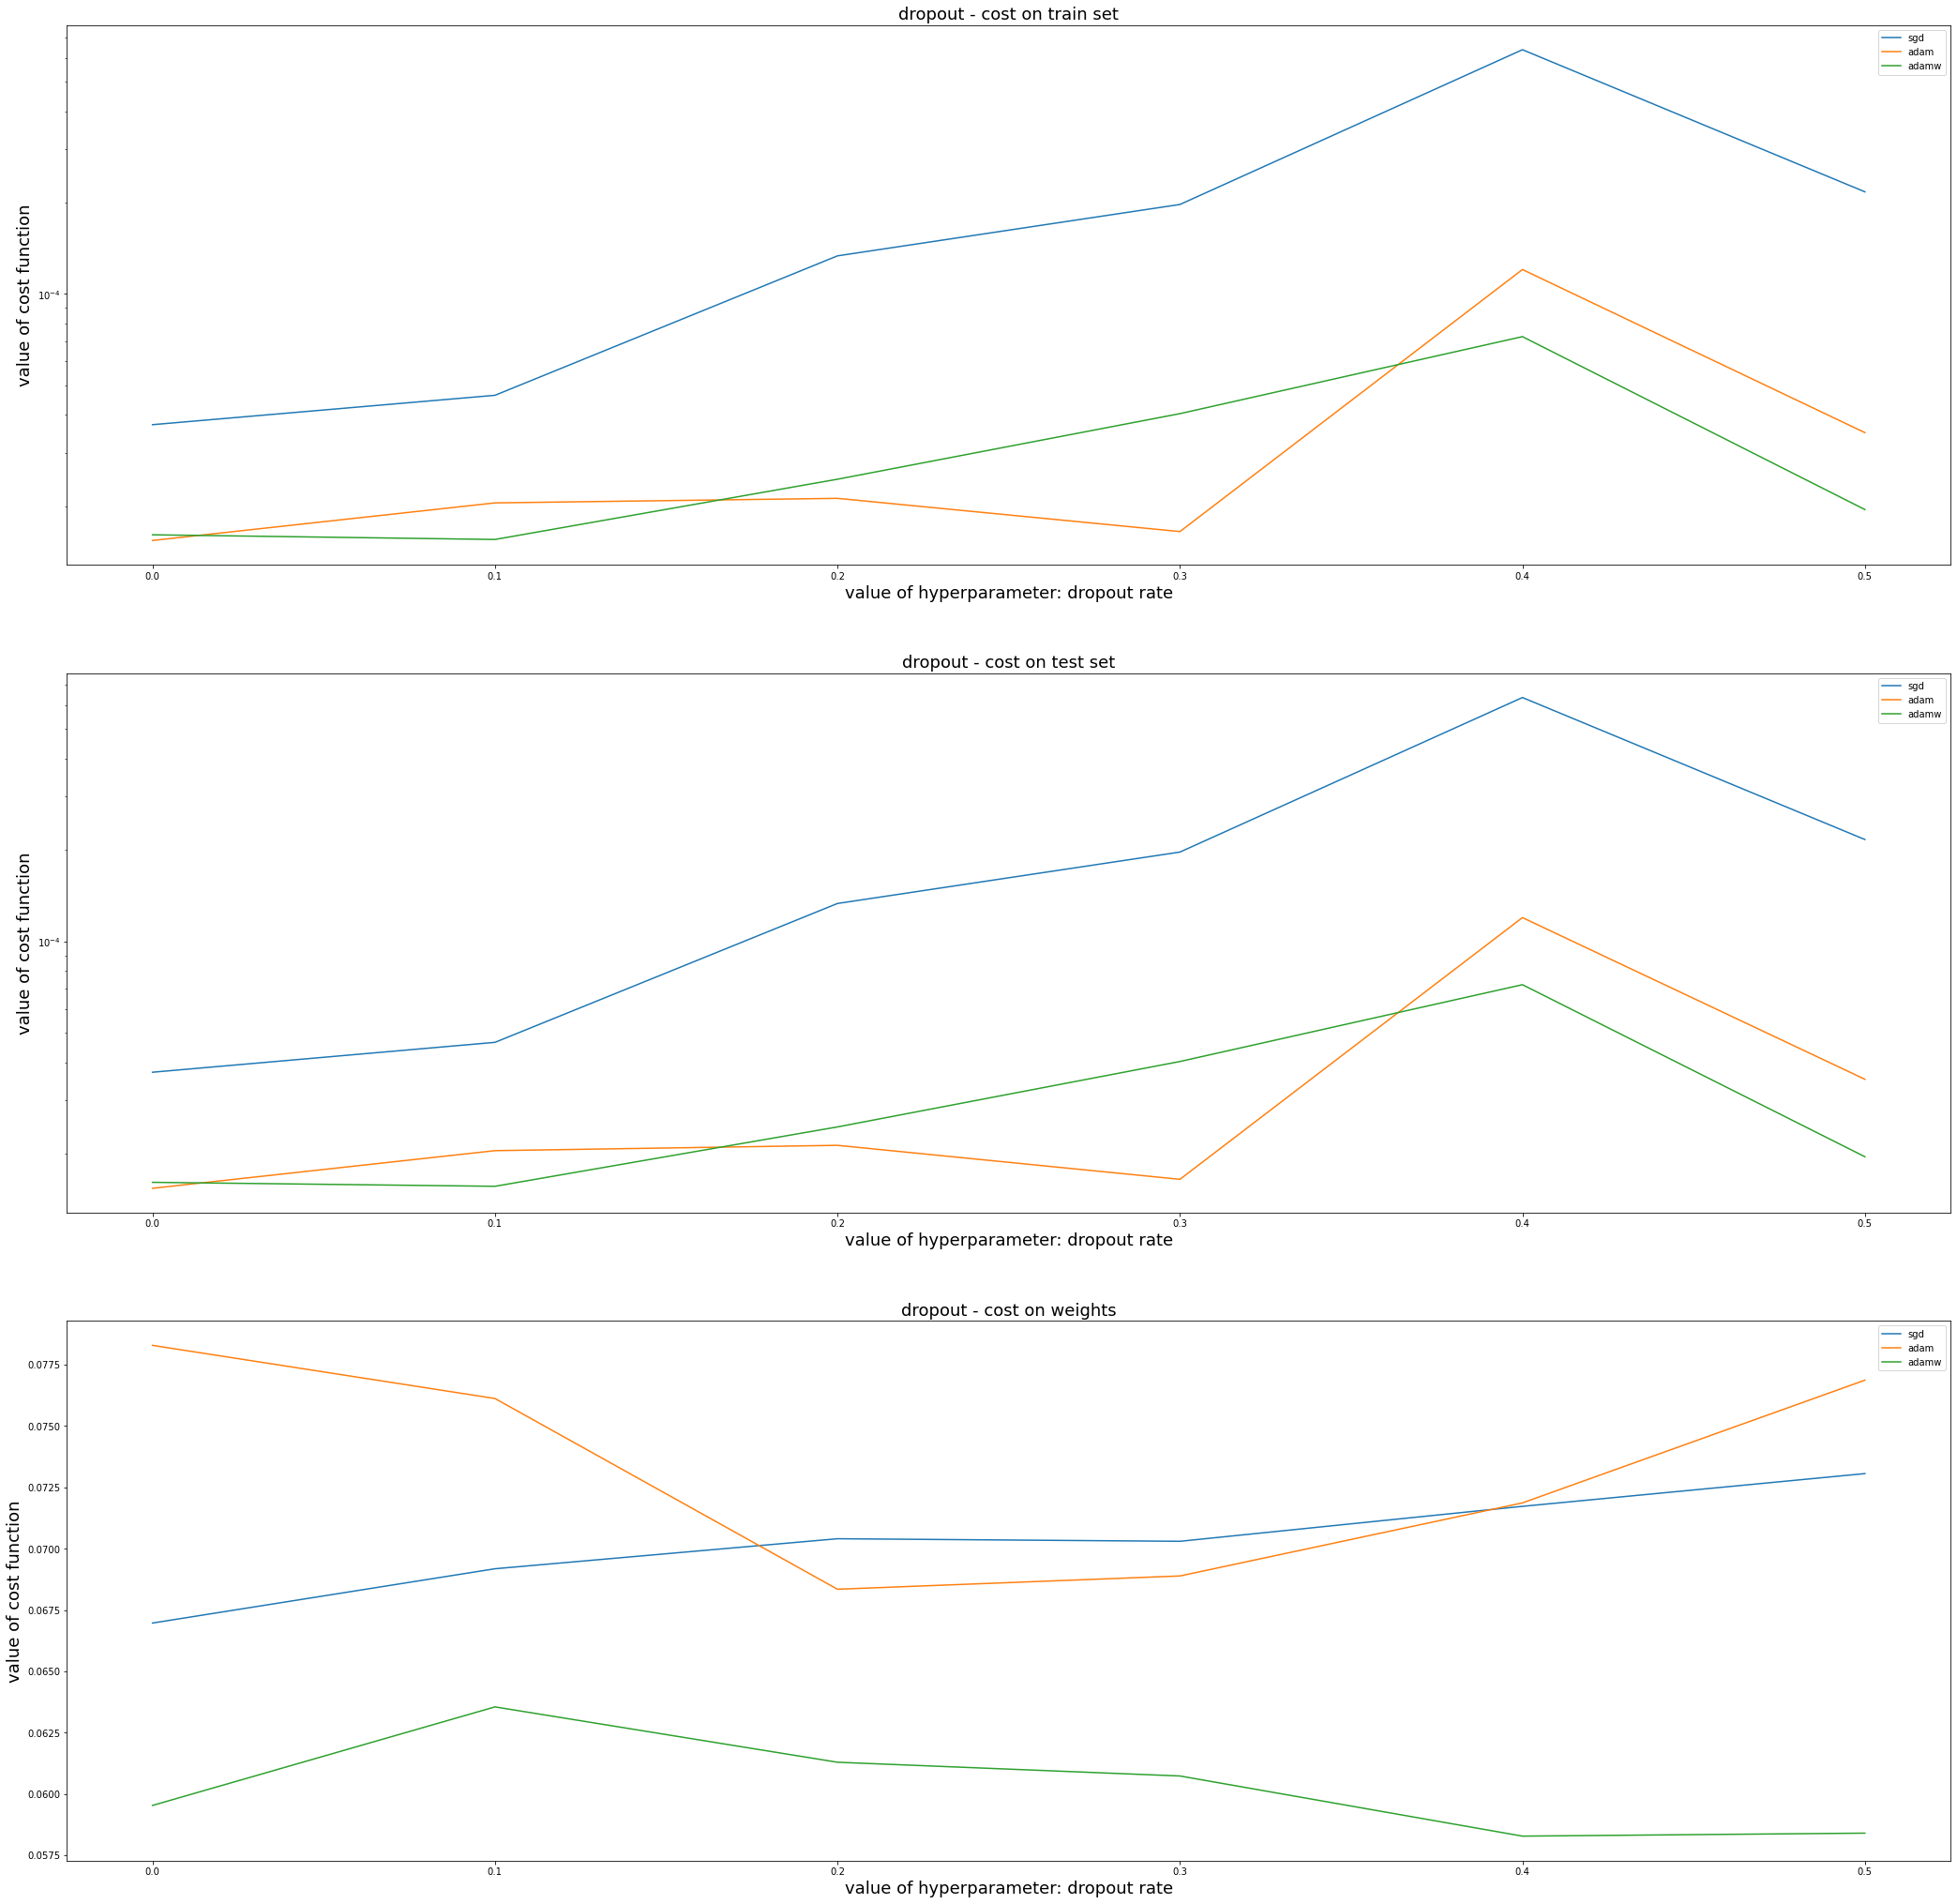

In [82]:
def one_last_time(results, name):
    for y in ['weight_decay', 'batch_norm', 'dropout']:
        if (y!='batch_norm'):
            fig, ax=plt.subplots(3, 1, figsize=(36, 36))
            if y!='dropout':
                for i in range(3):
                    ax[i].set_xscale('log')
            for i in range(2):
                ax[i].set_yscale('log')

            for x in results[y]:
                ax[0].plot(results[y][x][y], results[y][x]['train_y'], label=x)
                ax[1].plot(results[y][x][y], results[y][x]['test_y'], label=x)
                ax[2].plot(results[y][x][y], results[y][x]['w'], label=x)
                ax[0].set_title(f'{y} - cost on train set', size=18)        
                ax[1].set_title(f'{y} - cost on test set', size=18)
                ax[2].set_title(f'{y} - cost on weights', size=18)

            for i in range(3):
                ax[i].legend()
                ax[i].set_xlabel(f'value of hyperparameter: {"weight decay" if y=="weight_decay" else "dropout rate"}', size=18)
                ax[i].set_ylabel('value of cost function', size=18)

        else:
            fig, ax=plt.subplots(3, 3, figsize=(36, 36))
            for ij, x in enumerate(results[y]):
                dct1, dct2={}, {}
                data=results[y][x][y]
                num=0
                for f1, f2 in data:
                    if f1 not in dct1:
                        dct1[f1]=num
                        num+=1
                num=0
                for f1, f2 in data:
                    if f2 not in dct2:
                        dct2[f2]=num
                        num+=1
                c_train_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
                c_test_y=np.zeros((len(dct1), len(dct2)), dtype='float32')
                c_w=np.zeros((len(dct1), len(dct2)), dtype='float32')
                for f1, f2 in data:
                    c_train_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['train_y'], results[y][x][y]) if key==(f1, f2)][0]
                    c_test_y[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['test_y'], results[y][x][y]) if key==(f1, f2)][0]
                    c_w[dct1[f1],dct2[f2]]=[w for w, key in zip(results[y][x]['w'], results[y][x][y]) if key==(f1, f2)][0]

                sns.heatmap(c_train_y, ax=ax[0][ij], norm=matplotlib.colors.LogNorm())
                sns.heatmap(c_test_y, ax=ax[1][ij], norm=matplotlib.colors.LogNorm())
                sns.heatmap(c_w, ax=ax[2][ij])
                ax[0][ij].set_title(f'Batch optimization - cost on training set for {x} optimizer', size=18)
                ax[1][ij].set_title(f'Batch optimization - cost on test set for {x} optimizer', size=18)
                ax[2][ij].set_title(f'Batch optimization - cost on weights {x} optimizer', size=18)
            for i in range(3):
                for j in range(3):                       
                    ax[i][j].set_ylabel('value of hyperparameter: batch size', size=18)
                    ax[i][j].set_xlabel('value of hyperparameter: momentum', size=18)
                    ax[i][j].set_yticklabels([z for z in dct1])
                    ax[i][j].set_xticklabels([z for z in dct2])


        plt.show()
        fig.savefig(f'Comparision_{y}_{name}.png')
        
one_last_time(results1, 'ann')
one_last_time(results2, 'conv')

In [7]:
tf.__version__
#print(model.layers[1].bias.numpy())
#print(model.layers[1].weights)
#print(outer)

'2.3.0'

In [67]:
#post_system=signification.copy()
print(post_system)

{('dropout', 'sgd', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=1.1871598e-05>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1903882e-05>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.04295806>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04295806>)), ('dropout', 'adam', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=2.196863e-06>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1871592e-06>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.04570733>, <tf.Tensor: shape=(), dtype=float32, numpy=0.04570733>)), ('dropout', 'adamw', None, 32, 0.0): (<tf.Tensor: shape=(), dtype=float32, numpy=4.927325e-07>, <tf.Tensor: shape=(), dtype=float32, numpy=4.895053e-07>, (<tf.Tensor: shape=(), dtype=float32, numpy=0.027435124>, <tf.Tensor: shape=(), dtype=float32, numpy=0.027435124>)), ('dropout', 'sgd', None, 32, 0.1): (<tf.Tensor: shape=(), dtype=float32, numpy=0.00016742146>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00016698985>, (<tf.Tensor: shape=(), dtype=float32

In [4]:
#Hard Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            bx=x.weights[1]
            by=y.weights[1]
            x=x.weights[0]
            y=y.weights[0]
                        
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))
            
            group_dead, group_undead=[], []
            cos_sim=tf.keras.losses.CosineSimilarity(-1)

            for i in range(ln):
                group_dead.append(tf.concat([x[:,i], [by[i]]], axis=0))
                group_undead.append(tf.concat([y[:,i], [by[i]]], axis=0))

            hungary=[]
            for i, d_el in enumerate(group_dead):
                hungary.append([])
                for j, u_el in enumerate(group_undead):
                    # Gdyby to faktycznie było cosine similarity, tu powinien być minus;
                    # Ale to nie jest cosine similarity, to jest -cosine similarity z tensorflowa jako f. kosztu
                    hungary[i].append(cos_sim(d_el, u_el).numpy())

            m = munkres.Munkres()
            indexes = m.compute(hungary)
            cols=[v for w, v in indexes]
            transformator_lefty=np.zeros(shape=(ln, ln), dtype='float32')
            transformator_righty=np.zeros(shape=(ln, ln), dtype='float32')
            for i, v in enumerate(cols):
                transformator_lefty[v,i]=1
                transformator_righty[i,v]=1

            eld=y@transformator_lefty
            post_eld=tf.einsum('j,jj->j', by, transformator_lefty)
            if (ij<len(dead_model.layers)-1):
                if ij<len(dead_model.layers)-1 and is_dense(dead_model.layers[ij+1]):
                    point=ij+1
                elif ij<len(dead_model.layers)-2 and is_dense(dead_model.layers[ij+2]):
                    point=ij+2
                elif ij<len(dead_model.layers)-3 and is_dense(dead_model.layers[ij+3]):
                    point=ij+3
                else:
                    point=None
                if point is not None:
                    neue=transformator_righty@undead_model.layers[point].weights[0]

            better_numerator+=tf.reduce_sum((x-eld)*(x-eld))+tf.reduce_sum((bx-post_eld)*(bx-post_eld))
            
            denominator+=(x.shape[0]*x.shape[1])+bx.shape[0]
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator


#Eazy Cost
def kost(dead_model, undead_model):
    neue=None
    worse_numerator, better_numerator, denominator=0, 0, 0
        
    for ij, (x, y)  in enumerate(zip(dead_model.layers, undead_model.layers)):
        print(f'Processed layer: {ij}')
        if is_dense(x):
            x=x.weights[0]
            y=y.weights[0]
            ln=x.shape[1]
            
            if neue is not None:
                x=neue
                
            worse_numerator+=tf.reduce_sum((x-y)*(x-y))
            denominator+=(x.shape[0]*x.shape[1])
            print (f'LOG normal:    {tf.reduce_sum((x-y)*(x-y))/(x.shape[0]*x.shape[1])}')
            #print (f'LOG hungarian: {tf.reduce_sum((x-eld)*(x-eld))/(x.shape[0]*x.shape[1])}')
    return worse_numerator/denominator, worse_numerator/denominator